# Installing Dependencies & Libraries

In [ ]:
!pip install pdfplumber spacy phonenumbers sentence-transformers pandas numpy matplotlib seaborn reportlab
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 97.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 41.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 38.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Import Libraries & output directory of json extracted file

In [ ]:
# Libraries importing and output directory
import os
import re
import json
import warnings
import pdfplumber
import spacy
import phonenumbers

warnings.filterwarnings("ignore")

OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)


# Downloading NLP Model

In [ ]:
# NLP model downloading
try:
    nlp = spacy.load("en_core_web_sm")
except:
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

print("✅ SpaCy model ready")

✅ SpaCy model ready


# CV_Extractor Class for Information Extraction

In [ ]:
# Extraction Class
class EliteCVExtractor:
    def __init__(self, nlp):
        self.nlp = nlp
        self.headers = {
            'education': ['EDUCATION', 'ACADEMIC BACKGROUND', 'QUALIFICATIONS'],
            'experience': ['EXPERIENCE', 'ACADEMIC EXPERIENCE', 'TEACHING EXPERIENCE',
                           'PROFESSIONAL EXPERIENCE', 'WORK HISTORY', 'EMPLOYMENT', 'WORK EXPERIENCE'],
            'skills': ['SKILLS', 'TECHNICAL SKILLS', 'TECHNOLOGIES', 'COMPETENCIES'],
            'projects': ['PROJECTS', 'RESEARCH & PROJECTS', 'PUBLICATIONS', 'RESEARCH INTERESTS']
        }

    # Read PDF into list of lines
    def _read_pdf(self, pdf_path):
        lines = []
        try:
            with pdfplumber.open(pdf_path) as pdf:
                for page in pdf.pages:
                    text = page.extract_text()
                    if text:
                        # maintain original line breaks
                        lines.extend(text.split('\n'))
        except Exception as e:
            print(f"Error reading PDF: {e}")
        return lines

    # Main processing entry
    def process(self, pdf_path):
        print(f"\n📄 Processing: {pdf_path}")
        lines = self._read_pdf(pdf_path)
        full_text = "\n".join(lines)

        name = self._extract_name(lines)
        phone = self._extract_phone(full_text)
        email = self._extract_email(full_text)
        sections = self._segment_sections(lines)
        education_data = self._refine_education(sections.get('education', []))
        refined_skills = self._refine_skills(sections.get('skills', []), full_text)
        combined_experience = sections.get('experience', []) + sections.get('projects', [])

        return {
            "personal": {"name": name, "phone": phone, "email": email},
            "education": education_data,
            "experience": combined_experience,
            "skills": refined_skills,
            "raw_text": full_text
        }

    # NAME: spaCy PERSON in first 5 lines, then uppercase short-line fallback, else first line
    def _extract_name(self, lines):
        for line in lines[:5]:
            clean = line.strip()
            if not clean:
                continue
            doc = self.nlp(clean)
            for ent in doc.ents:
                if ent.label_ == "PERSON" and len(clean.split()) < 6:
                    return ent.text.strip()
            if clean.isupper() and len(clean.split()) < 5:
                return clean
        return lines[0].strip() if lines else "Unknown"

    # PHONE: Try phonenumbers first (international parsing), then robust regex fallbacks
    def _extract_phone(self, text):
        # 1) phonenumbers library: iterate matches and pick the first plausible MSISDN
        try:
            for match in phonenumbers.PhoneNumberMatcher(text, "PS"):  # region PS (Palestine) as hint
                num = match.number
                # return: international format when possible
                try:
                    formatted = phonenumbers.format_number(num, phonenumbers.PhoneNumberFormat.INTERNATIONAL)
                    return formatted
                except:
                    return phonenumbers.format_number(num, phonenumbers.PhoneNumberFormat.E164)
        except Exception:
            pass

        # 2) Fallback regexes similar to original patterns (local formats)
        patterns = [
            r'\(\+97[02]\)\s?\d{6,12}',       # (+970)599320207
            r'\+97[02]\s?\d{1,3}[\s-]?\d{3,6}',   # +970 599 320207 (broad)
            r'\b05\d{7,9}\b',                 # 0599320207 or 059 932 0207 (compact)
            r'\b\+?\d{7,15}\b'                # generic international fallback
        ]
        for p in patterns:
            match = re.search(p, text)
            if match:
                return match.group(0).strip()
        return "Not Found"

    # EMAIL:robust regex
    def _extract_email(self, text):
        match = re.search(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b', text)
        return match.group(0) if match else "Not Found"

    # SECTION SEGMENTATION: exact or startswith header matching, protect against long false heads
    def _segment_sections(self, lines):
        sections = {k: [] for k in self.headers.keys()}
        current_sec = None

        for line in lines:
            clean = line.strip()
            if not clean:
                continue
            up = clean.upper()

            # check headers
            header_found = False
            for sec, keys in self.headers.items():
                for k in keys:
                    if up == k or up.startswith(k):
                        # avoid false positives: header lines are usually short
                        if len(up) < 60:
                            current_sec = sec
                            header_found = True
                            break
                if header_found:
                    break

            if header_found:
                continue

            if current_sec:
                sections[current_sec].append(clean)

        return sections

    # EDUCATION: preserve lines that look like degree lines; keep Bachelor's with apostrophe
    def _refine_education(self, edu_lines):
        refined = []
        for l in edu_lines:
            if len(l.strip()) < 4:
                continue
            # keep common degree words including Bachelor's with apostrophe
            up = l.upper()
            if any(w in up for w in ['BACHELOR', "BACHELOR'S",'B.SC', 'MASTER', 'M.SC', 'PHD', 'PH.D', 'DOCTOR']):
                refined.append(l.strip())
            else:
                # also include institution-looking lines (University, College, Institute)
                if any(x in up for x in ['UNIVERSITY', 'COLLEGE', 'INSTITUTE', 'SCHOOL', 'FACULTY']):
                    refined.append(l.strip())
                # or include lines that contain years (e.g., 2018 - 2022)
                elif re.search(r'\b(19|20)\d{2}\b', l):
                    refined.append(l.strip())
                else:
                    # include if it's a reasonable sentence length (to not lose content)
                    if len(l.strip()) > 30:
                        refined.append(l.strip())
        return refined

    # SKILLS: NLP-based plus whitelist; keep deduplicated results
    def _refine_skills(self, skill_lines, full_text):
        text = " ".join(skill_lines) if skill_lines and sum(len(s) for s in skill_lines) > 20 else full_text
        doc = self.nlp(text)
        skills = set()

        # Noun tokens and proper nouns
        for token in doc:
            if token.pos_ in ['PROPN', 'NOUN'] and len(token.text) > 2:
                # filter tokens that are just general words
                cleaned = re.sub(r'[^A-Za-z0-9\+\#\.\-]', '', token.text)
                if len(cleaned) > 1:
                    skills.add(cleaned)

        # whitelist for common tech items/spellings
        whitelist = ['C++', 'C#', 'Go', 'React', 'Vue', 'Node.js', 'Latex', 'Docker', 'Kubernetes',
                     'SQL', 'NoSQL', 'Git', 'Linux', 'Matlab', 'Simulink', 'IoT', 'Python', 'Java',
                     'TensorFlow', 'PyTorch', 'OpenCV', 'Spark', 'AWS', 'Azure', 'MongoDB', 'Flutter',
                     'React Native']
        for w in whitelist:
            if re.search(r'\b' + re.escape(w) + r'\b', text, flags=re.IGNORECASE):
                skills.add(w)

        # final cleanup & sort
        cleaned_skills = []
        for s in skills:
            s2 = s.strip()
            if len(s2) > 1:
                cleaned_skills.append(s2)

        return sorted(set(cleaned_skills), key=lambda x: x.lower())


# Main (Results) & Saving json output file

In [ ]:
# Results
CV_FILE = "Anas_CV.pdf"   # cv file path
if not os.path.exists(CV_FILE):
    print(f"❌ '{CV_FILE}' not found. Upload the PDF or set CV_FILE to the correct path.")
else:
    extractor = EliteCVExtractor(nlp)
    cv_data = extractor.process(CV_FILE)
    out_path = os.path.join(OUTPUT_DIR, "cv_extracted.json")
    with open(out_path, "w", encoding="utf-8") as f:
        json.dump(cv_data, f, indent=4, ensure_ascii=False)
    print(f"✅ Extracted saved → {out_path}")
    print("\nPersonal info:")
    print(json.dumps(cv_data['personal'], indent=2))
    print("\nEducation lines (count):", len(cv_data['education']))
    print("Skills (count):", len(cv_data['skills']))



📄 Processing: Anas_CV.pdf
✅ Extracted saved → output/cv_extracted.json

Personal info:
{
  "name": "ANAS MELHEM",
  "phone": "+970 599 320 207",
  "email": "a.melhem@ptuk.edu.ps"
}

Education lines (count): 10
Skills (count): 20


# Starting ATS_Scoring & S-BERT Model Matching

# Import Libraries & Output Model & Directories

In [ ]:
import os
import json
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sentence_transformers import SentenceTransformer, util

warnings.filterwarnings("ignore")

OUTPUT_DIR = "output"
MODEL_DIR = "cv_ai_models"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)

# Check for json extracted file

In [ ]:
cv_path = os.path.join(OUTPUT_DIR, "cv_extracted.json")

if not os.path.exists(cv_path):
    raise FileNotFoundError("❌ cv_extracted.json not found. Run extractor notebook first.")

with open(cv_path, "r", encoding="utf-8") as f:
    cv_data = json.load(f)

print("✅ CV loaded")
print("Name:", cv_data["personal"]["name"])
print("Experience lines:", len(cv_data["experience"]))
print("Skills:", len(cv_data["skills"]))

✅ CV loaded
Name: ANAS MELHEM
Experience lines: 73
Skills: 20


# Check Dataset of Internships

In [ ]:
csv_path = "palestinian_internships_200.csv"

if not os.path.exists(csv_path):
    raise FileNotFoundError("❌ Internship CSV not found")

df = pd.read_csv(csv_path).fillna("")
print("✅ Internship dataset loaded:", df.shape)

✅ Internship dataset loaded: (200, 12)


# Load S-BERT model files to a directory

In [ ]:
model_path = os.path.join(MODEL_DIR, "sbert_model")

if not os.path.exists(model_path):
    print("⏳ Downloading SBERT model...")
    sbert = SentenceTransformer("all-MiniLM-L6-v2")
    sbert.save(model_path)
else:
    sbert = SentenceTransformer(model_path)

print("✅ SBERT ready")


⏳ Downloading SBERT model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ SBERT ready


# Class Matcher of Internships

In [ ]:
class InternshipMatcher:
    def __init__(self, model, df):
        self.model = model
        self.df = df.copy()

        self.df["combined_text"] = (
            self.df["position"] + " " +
            self.df["required_skills"] + " " +
            self.df["description"]
        )

        print("⏳ Encoding internship embeddings...")
        self.job_embeddings = self.model.encode(
            self.df["combined_text"].tolist(),
            convert_to_tensor=True
        )


    # ATS SCORE (100 POINTS)

    def calculate_ats_score(self, cv):
        breakdown = {}

        # 1. Contact Info — 15
        contact = 0
        if cv["personal"]["name"] != "Unknown": contact += 5
        if cv["personal"]["phone"] != "Not Found": contact += 5
        if cv["personal"]["email"] != "Not Found": contact += 5
        breakdown["Contact"] = contact

        # 2. Education — 35
        edu_text = " ".join(cv["education"]).upper()
        edu_score = 10  # base for presence

        if "PHD" in edu_text or "DOCTOR" in edu_text:
            edu_score += 25
        elif "MASTER" in edu_text or "M.SC" in edu_text:
            edu_score += 15
        elif "BACHELOR" in edu_text or "B.SC" in edu_text:
            edu_score += 10

        breakdown["Education"] = min(35, edu_score)

        # 3. Experience — 30
        exp_text = " ".join(cv["experience"]).upper()
        exp_score = 10  # base

        if any(k in exp_text for k in ["PROFESSOR", "LECTURER", "MANAGER", "LEAD", "CHAIR"]):
            exp_score += 20
        elif len(cv["experience"]) > 15:
            exp_score += 15
        elif len(cv["experience"]) > 5:
            exp_score += 5

        breakdown["Experience"] = min(30, exp_score)

        # 4. Skills — 20
        breakdown["Skills"] = min(20, len(cv["skills"]) + 5)

        total = sum(breakdown.values())
        return total, breakdown


    # SEMANTIC MATCHING

    def match(self, cv, ats_score):
        candidate_text = (
            " ".join(cv["skills"]) + " " +
            " ".join(cv["experience"]) + " " +
            " ".join(cv["education"])
        )

        cand_embedding = self.model.encode(candidate_text, convert_to_tensor=True)
        similarities = util.cos_sim(cand_embedding, self.job_embeddings)[0]

        results = []
        for idx, sim in enumerate(similarities):
            semantic_pct = float(sim) * 100

            final_score = (
                0.6 * semantic_pct +
                0.4 * ats_score
            )

            results.append({
                "company": self.df.iloc[idx]["company"],
                "position": self.df.iloc[idx]["position"],
                "location": self.df.iloc[idx]["location"],
                "stipend": float(self.df.iloc[idx]["monthly_stipend"]),
                "semantic_score": semantic_pct,
                "final_score": final_score
            })

        return sorted(results, key=lambda x: x["final_score"], reverse=True)


# Calling of Matcher & Printing Results

In [ ]:
matcher = InternshipMatcher(sbert, df)

ats_score, ats_breakdown = matcher.calculate_ats_score(cv_data)
matches = matcher.match(cv_data, ats_score)

print(f"\n📝 ATS SCORE: {ats_score}/100")
print("Breakdown:", ats_breakdown)

print("\n🏆 Top 5 Matches:")
for i, m in enumerate(matches[:5], 1):
    print(f"{i}. {m['company']} — {m['position']} ({m['final_score']:.1f}%)")

⏳ Encoding internship embeddings...

📝 ATS SCORE: 100/100
Breakdown: {'Contact': 15, 'Education': 35, 'Experience': 30, 'Skills': 20}

🏆 Top 5 Matches:
1. Bank of Palestine — Digital Forensics Intern (78.9%)
2. Exalt Technologies — Ethical Hacking Intern (75.4%)
3. Exalt Technologies — Security Operations Intern (75.3%)
4. Exalt Technologies — Full Stack Developer Intern (74.0%)
5. Exalt Technologies — Digital Forensics Intern (71.6%)


# Data Analysis & Results Visualization

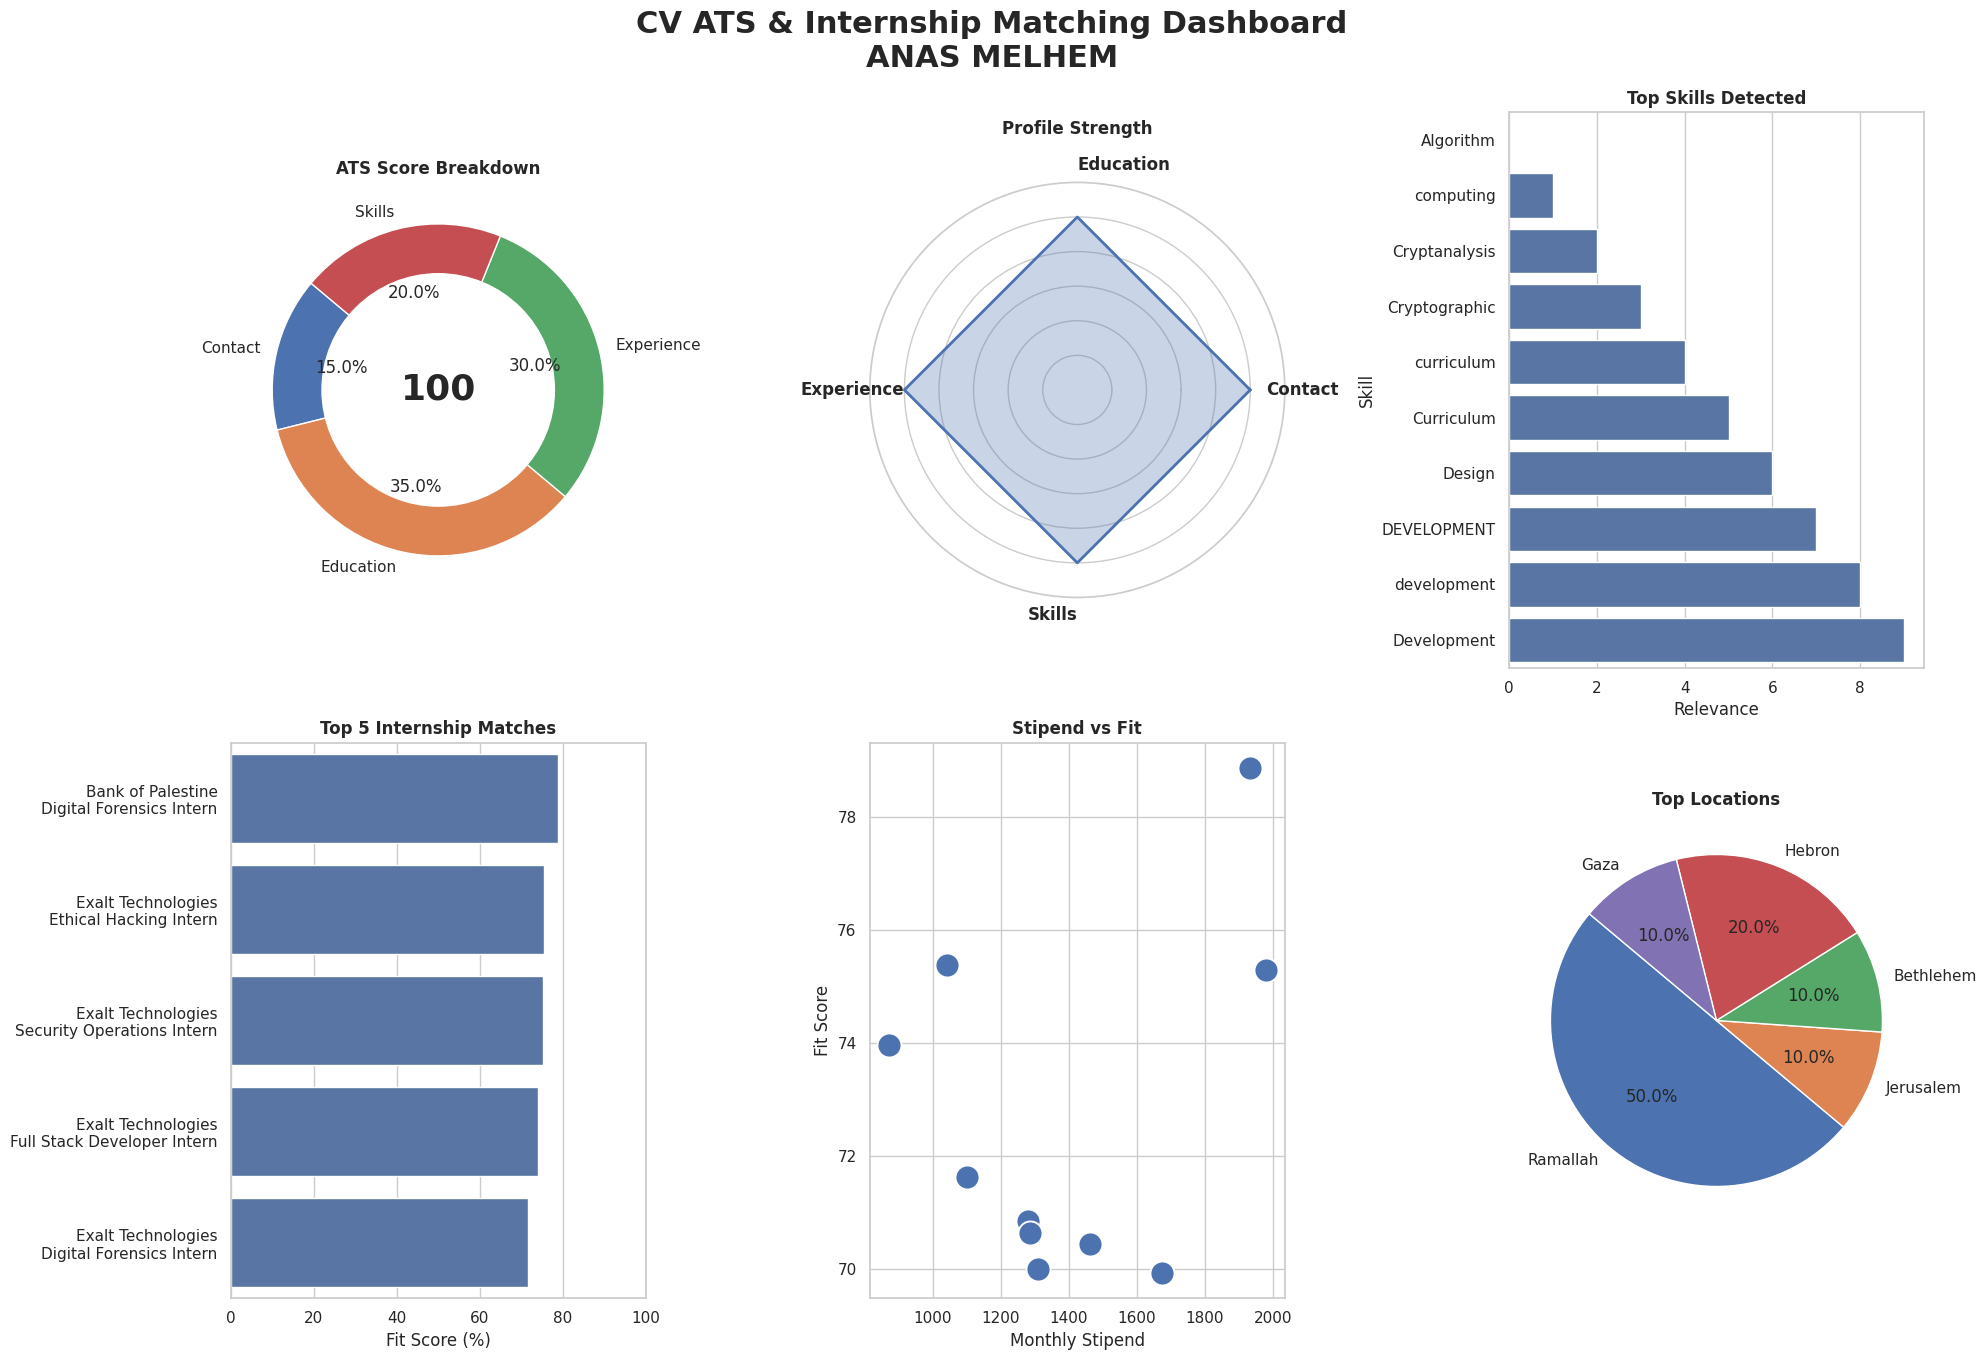

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

sns.set_theme(style="whitegrid")

fig = plt.figure(figsize=(20, 14))
fig.suptitle(
    f"CV ATS & Internship Matching Dashboard\n{cv_data['personal']['name']}",
    fontsize=22,
    fontweight="bold",
    y=0.97
)


# 1. ATS SCORE DONUT

ax1 = fig.add_subplot(231)
ax1.pie(
    ats_breakdown.values(),
    labels=ats_breakdown.keys(),
    autopct="%1.1f%%",
    startangle=140
)
ax1.add_artist(plt.Circle((0, 0), 0.7, fc="white"))
ax1.text(0, 0, f"{ats_score}", ha="center", va="center", fontsize=26, fontweight="bold")
ax1.set_title("ATS Score Breakdown", fontweight="bold")


# 2. RADAR

ax2 = fig.add_subplot(232, polar=True)

categories = list(ats_breakdown.keys())
values = list(ats_breakdown.values())
max_values = [15, 35, 30, 20]

# Normalize to %
values_norm = [(v / m) * 100 for v, m in zip(values, max_values)]

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False)
angles_closed = np.concatenate([angles, [angles[0]]])
values_closed = values_norm + [values_norm[0]]

# Radar plot
ax2.plot(angles_closed, values_closed, linewidth=2)
ax2.fill(angles_closed, values_closed, alpha=0.3)

# Radar scale
ax2.set_ylim(0, 120)
ax2.set_yticks([20, 40, 60, 80 , 100])
ax2.set_yticklabels([])  # hide radial labels

# REMOVE default category labels completely
ax2.set_xticks([])

# 👉 MANUAL LABEL PLACEMENT (outside the chart)
label_radius = 130  # distance outside radar

for angle, label in zip(angles, categories):
    ha = "center"
    if angle == 0:
        ha = "center"
    elif 0 < angle < np.pi:
        ha = "left"
    elif np.pi < angle < 2 * np.pi:
        ha = "right"

    ax2.text(
        angle,
        label_radius,
        label,
        ha=ha,
        va="center",
        fontsize=12,
        fontweight="bold"
    )

ax2.set_title("Profile Strength", pad=35, fontweight="bold")



# 3. TOP SKILLS BAR

ax3 = fig.add_subplot(233)
top_skills = cv_data["skills"][:10]

sns.barplot(
    x=list(range(len(top_skills))),
    y=top_skills,
    ax=ax3
)

ax3.set_title("Top Skills Detected", fontweight="bold")
ax3.set_xlabel("Relevance")
ax3.set_ylabel("Skill")


# 4. TOP 5 MATCHES

ax4 = fig.add_subplot(234)
top5 = matches[:5]

labels = [f"{m['company']}\n{m['position']}" for m in top5]
scores = [m["final_score"] for m in top5]

sns.barplot(x=scores, y=labels, ax=ax4)
ax4.set_xlim(0, 100)
ax4.set_title("Top 5 Internship Matches", fontweight="bold")
ax4.set_xlabel("Fit Score (%)")


# 5. STIPEND VS FIT

ax5 = fig.add_subplot(235)
top10 = matches[:10]

sns.scatterplot(
    x=[m["stipend"] for m in top10],
    y=[m["final_score"] for m in top10],
    s=300,
    ax=ax5
)

ax5.set_xlabel("Monthly Stipend")
ax5.set_ylabel("Fit Score")
ax5.set_title("Stipend vs Fit", fontweight="bold")


# 6. LOCATION DISTRIBUTION

ax6 = fig.add_subplot(236)
locations = [m["location"] for m in matches[:10]]
loc_counts = Counter(locations)

ax6.pie(
    loc_counts.values(),
    labels=loc_counts.keys(),
    autopct="%1.1f%%",
    startangle=140
)
ax6.set_title("Top Locations", fontweight="bold")

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "ats_matching_dashboard.png"), dpi=300)
plt.show()